## ARCH
### Auto Regressive Conditional Heteroeskedacity
[Notes](https://learn.london.ac.uk/pluginfile.php/265820/mod_resource/content/4/Topic%208%20Lecture%203%20Arch%20notes.pdf)



Trying to predict the squares of the errors

In [3]:
import pandas as pd
import yfinance
import matplotlib.pyplot as plt
import statsmodels.api as sm
tesla_frame = yfinance.Ticker('TSLA').history(start='2015-01-01', end='2022-01-01', interval='1d').reset_index()['Close'].to_frame()

plt.rcParams['figure.figsize'] = [16, 8]
series = tesla_frame['Close']
ar_deg = 4

model = sm.tsa.AutoReg(series, lags=ar_deg, trend='n').fit()
prediction = model.predict()
tesla_frame['Prediction'] = prediction
tesla_frame[10:20]

,Close,Prediction
10,12.871333,12.810506
11,12.795333,12.850338
12,13.104666,12.819380
13,13.441333,13.130824
14,13.419333,13.466009
15,13.770000,13.469873
16,13.732000,13.812911
17,13.291333,13.764424
18,13.680000,13.340786
19,13.573333,13.693051


<AxesSubplot:>

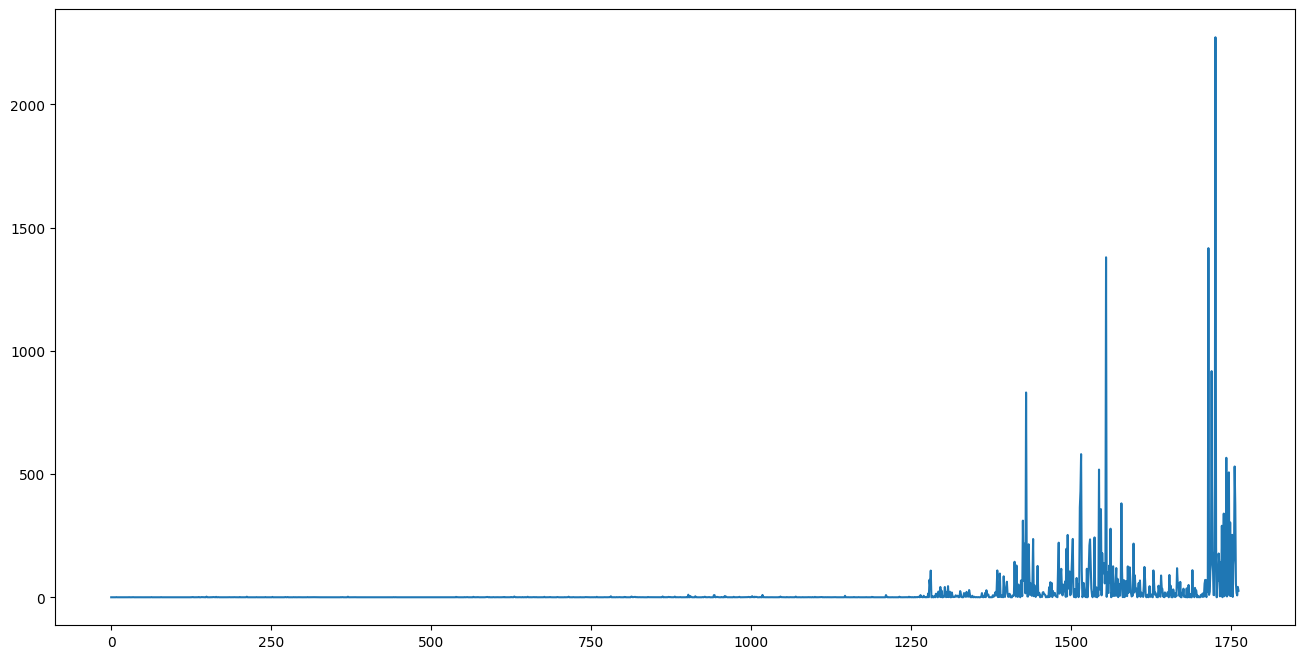

In [4]:
error_sq = (series - prediction) ** 2
error_sq[error_sq.isna()] = 0
error_sq.plot()

Predict error using ARCH model  
Linear sum of previous square errors with a constant terms  
Biased AR model on the error squared estimates

Conditional: heteroeskedacity is not constant
Heteroskedasticy: different - means that the variance changes



Use the inbuilt ARIMA code, to compute ARCH. In this example,
we will use an ARCH(5) model. The data is the error_sq we computed above. Since this is a
biased model (i.e. with a constant term) we will have the parameter trend='c'

In [5]:
arch_deg = 4
arch_model = sm.tsa.AutoReg(error_sq, lags=arch_deg, trend='c').fit()
error_prediction_sq = arch_model.predict()
error_prediction_sq[10:20]

10    9.593334
11    9.546728
12    9.594393
13    9.541070
14    9.551048
15    9.536600
16    9.554493
17    9.544978
18    9.571624
19    9.577883
dtype: float64

<AxesSubplot:>

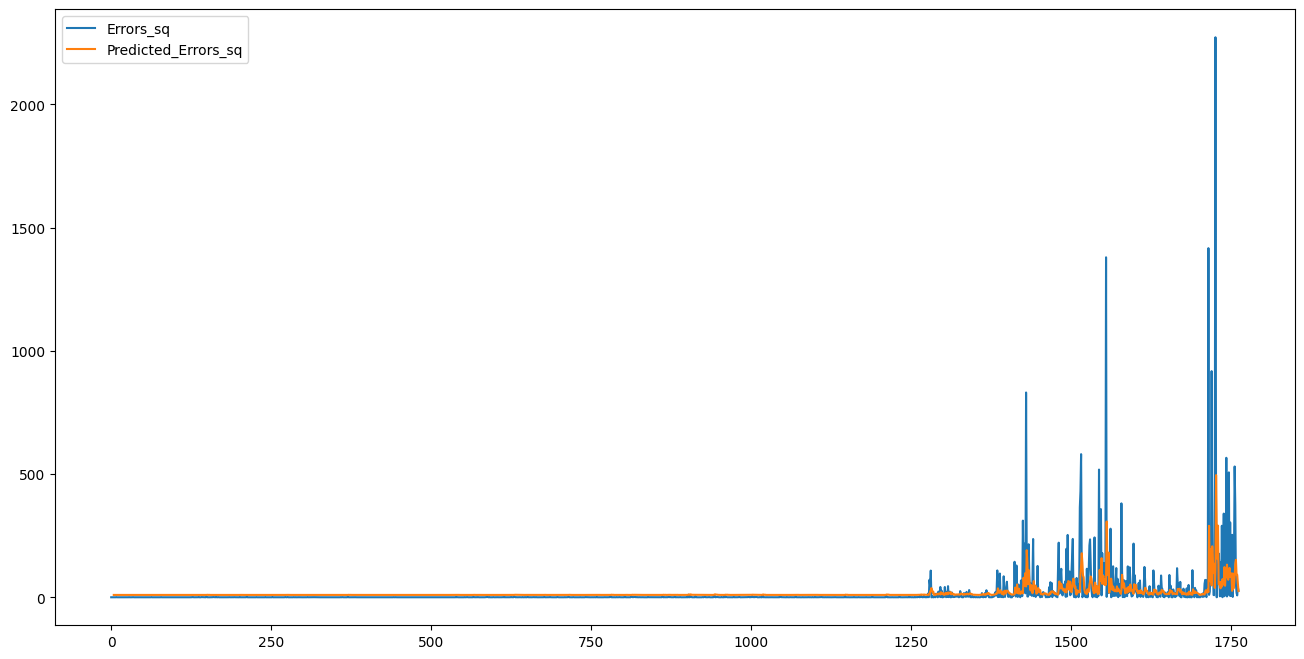

In [6]:
# make new frame of the error squared and prediction
tesla_errorsq_frame = pd.DataFrame(columns = ['Errors_sq','Predicted_Errors_sq'])
tesla_errorsq_frame ['Errors_sq']= error_sq
tesla_errorsq_frame['Predicted_Errors_sq'] = error_prediction_sq
tesla_errorsq_frame.plot()

As before, we are going to use the error prediction as the standard deviation of our predictions.  

We will have a one standard deviation envelope around the prediction.   
The Lower Bound will be the prediction - the error prediction.  
The Upper Bound will be the prediction + the error prediction.   
Let's make another dataframe. This one of the prediction envelopes.



In [7]:
import numpy as np
error_prediction = np.sqrt(arch_model.predict())
tesla_envelope_df = tesla_frame['Close'].to_frame()
tesla_envelope_df ['Lower'] = prediction - error_prediction
tesla_envelope_df ['Upper'] = prediction + error_prediction
tesla_envelope_df [100:110]

,Close,Lower,Upper
100,16.763332,13.449092,19.621778
101,16.719999,13.704643,19.880784
102,16.629999,13.670852,19.845090
103,16.556665,13.590992,19.765073
104,16.599333,13.497736,19.673414
105,16.394667,13.538370,19.711465
106,16.609333,13.336936,19.513322
107,17.086000,13.550387,19.726934
108,17.066666,14.014175,20.200642
109,16.713333,14.031091,20.211791


<AxesSubplot:>

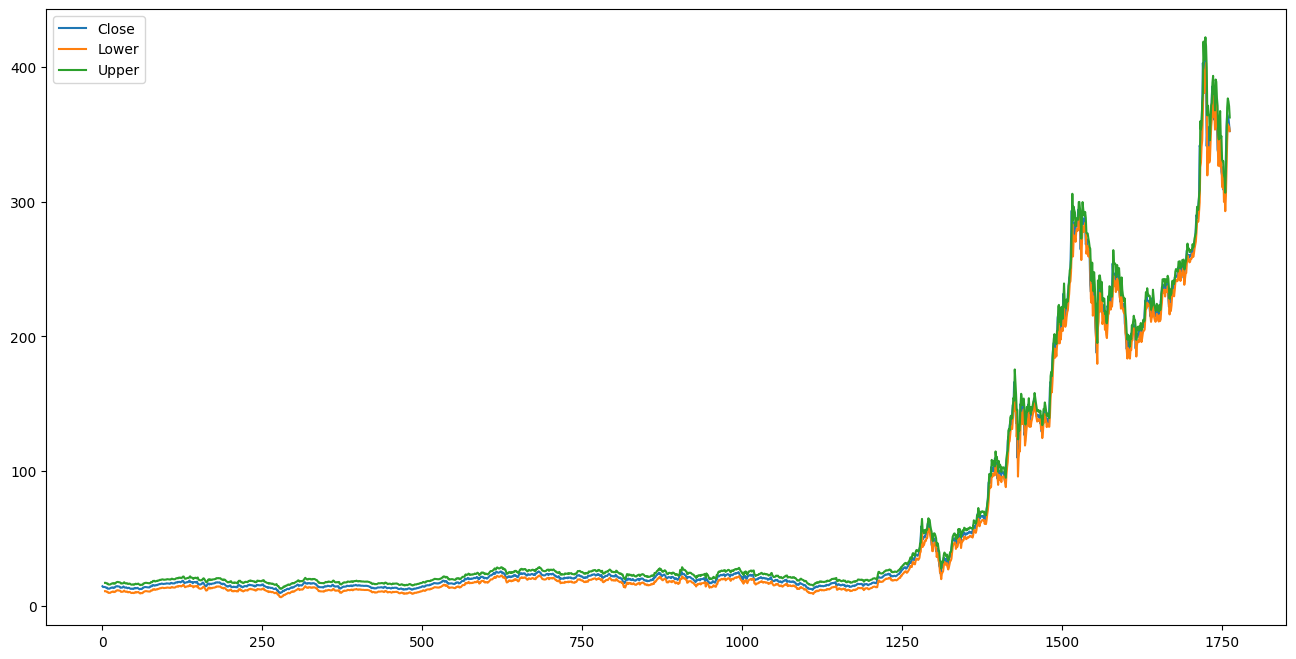

In [8]:
tesla_envelope_df.plot()

If this is well calibrated the close should be within this envelope about as often the normal
distribution is within one standard deviation. That is about 68 percent. We will test that and also
about how often the closing price is within two standard deviations, which should be about 96
percent.



In [9]:
in_one_sd = (tesla_envelope_df['Upper'] > tesla_envelope_df['Close']) & (tesla_envelope_df['Lower'] < tesla_envelope_df['Close'])
print("Percentage within 1 standard deviation", in_one_sd.mean() * 100)

in_two_sd = (prediction - 2 * error_prediction < tesla_envelope_df['Close']) & (prediction + 2*error_prediction > tesla_envelope_df['Close'])

print("Percentage within two standard deviations", in_two_sd.mean() * 100)

Percentage within 1 standard deviation 89.79013045944413
Percentage within two standard deviations 96.14293817356779


To get a sense of how the prediction is working as a function of time, I am going to draw the
graph of a function that is 1 when the price is within one standard deviation and when it is not.

<AxesSubplot:>

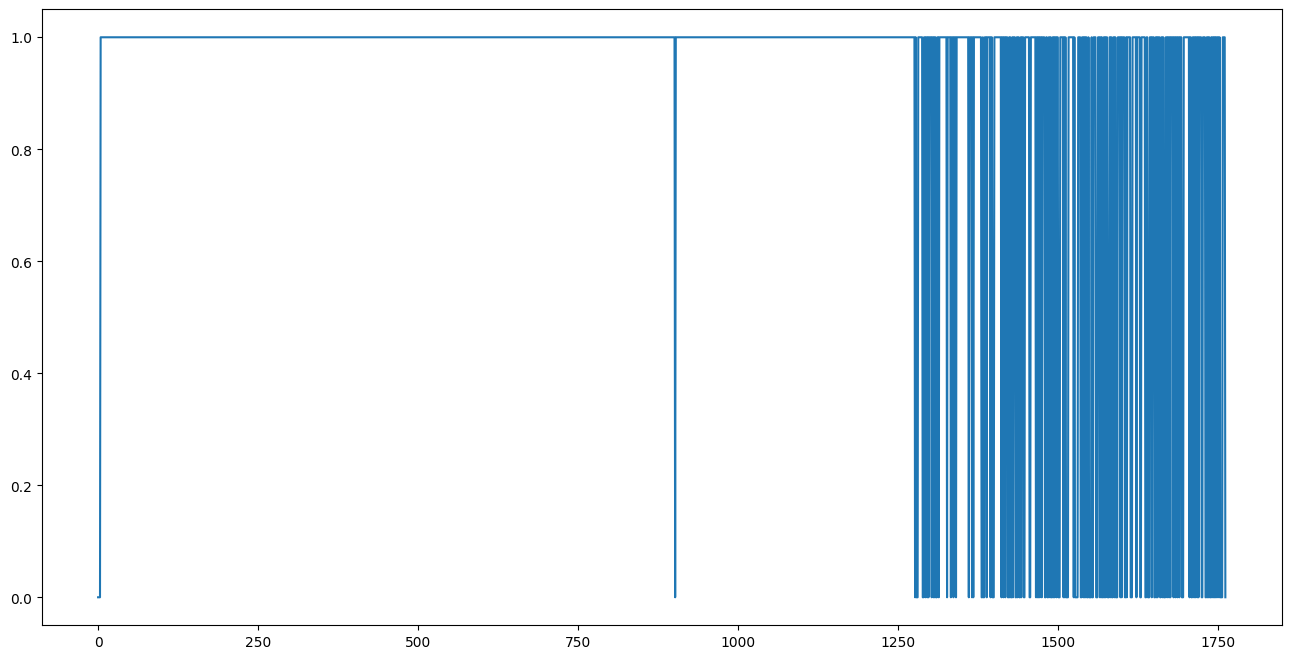

In [10]:
series = 1 * ((tesla_envelope_df['Upper'] > tesla_envelope_df['Close']) & (tesla_envelope_df['Lower'] < tesla_envelope_df['Close']))
series.plot()

# GARCH
[Notes](https://learn.london.ac.uk/pluginfile.php/265844/mod_resource/content/5/Topic%208%20Lecture%204%20GARCH.pdf)


Generalization of ARCH  




In [12]:
tesla_frame = yfinance.Ticker("TSLA").history(start='2020-01-01', end='2022-01-01', interval='1d').reset_index()['Close'].to_frame()
series = tesla_frame['Close']
ar_deg = 4
model = sm.tsa.AutoReg(series, lags=ar_deg, trend='n').fit()
prediction = model.predict()

tesla_frame['Prediction'] = prediction
error_sq = (series - prediction) ** 2
error_sq[error_sq.isna()] = 0

garch_model = sm.tsa.ARIMA(error_sq, order=(4,0,3), trend ='c').fit()
arch_model = sm.tsa.ARIMA(error_sq, order=(4,0,0), trend ='c').fit()

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


As before, we are going to use this to talk about a confidence interval of our predictions. Let’s do
both the ARCH and GARCH and compare.

In [13]:
garch_error_prediction = np.sqrt(garch_model.predict())
arch_error_prediction = np.sqrt(arch_model.predict())
tesla_garch_df = series.to_frame()
tesla_garch_df['Garch Lower'] = prediction - garch_error_prediction
tesla_garch_df['Garch Upper'] = prediction + garch_error_prediction
tesla_garch_df['Arch Lower'] = prediction - arch_error_prediction
tesla_garch_df['Arch Upper'] = prediction + arch_error_prediction
tesla_garch_df[100:110]

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Close,Garch Lower,Garch Upper,Arch Lower,Arch Upper
100,54.681999,50.288110,59.176908,48.300982,61.164036
101,53.720665,50.399792,59.101158,48.320321,61.180629
102,55.666664,49.519004,58.171907,47.401197,60.289714
103,59.873333,51.364038,60.131101,49.275179,62.219959
104,58.770664,55.385078,64.483090,53.289743,66.578425
105,58.863998,54.632267,63.544297,52.561831,65.614733
106,57.625332,54.953199,63.458981,52.753818,65.658362
107,59.043999,53.263384,62.112875,51.132745,64.243515
108,63.327999,54.496738,63.766080,52.662457,65.600362
109,62.711334,58.624865,68.113201,56.724155,70.013912


GARCH bounds tighter than ARCH ones

Look at the % out of hte bonds for both sets of prediction


In [14]:
in_one_sd = (tesla_garch_df['Garch Upper'] > tesla_garch_df['Close']) & (tesla_garch_df['Garch Lower'] < tesla_garch_df['Close'])
print("Percentage within 1 standard deviation", in_one_sd.mean() * 100)
in_two_sd = (prediction - 2 * garch_error_prediction < tesla_garch_df['Close']) & (prediction + 2 * garch_error_prediction > tesla_garch_df['Close'])
print("Percentage within two standard deviations", in_two_sd.mean() * 100)

Percentage within 1 standard deviation 74.05940594059406
Percentage within two standard deviations 93.46534653465348


In [15]:
in_one_sd = (tesla_garch_df['Arch Upper'] > tesla_garch_df['Close']) & (tesla_garch_df['Arch Lower'] < tesla_garch_df['Close'])
print("Percentage within 1 standard deviation", in_one_sd.mean() * 100)

in_two_sd = (prediction - 2 * arch_error_prediction < tesla_garch_df['Close']) & (prediction + 2 * arch_error_prediction > tesla_garch_df['Close'])
print("Percentage within two standard deviations", in_two_sd.mean() * 100)

Percentage within 1 standard deviation 77.02970297029704
Percentage within two standard deviations 94.05940594059405


It looks like it could be tighter still but it is good.  

We have looked at predicting error rates, assuming they vary. The two algorithms are parallel to AR and ARMA, working on squares of errors, rather than values of the series. 

You should now be able to use statsmodels to produce ARCH and GARCH models.

You should be able to see how well the percentages caught within one or two standard deviations of the prediction. 

In the next lesson, we are going to look more at likelihood calculations and their use in evaluations.